In [75]:
# music parts
PARTS = [0, 73, 146, 292, 584, 1024]
WIDTH = 4 
MAX_HEIGHT = 16
FRAME_RATE_FILE = "./Data/JSON/frameRate.json"
FRAME_RATE = 16384
# BASE_RATE  = 48000 

# import process is very slow
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [76]:
def GetWavFileName(filename: str):
    lis = filename.split('.')[:-1]
    lis.append('wav')
    return ('.'.join(lis)).replace('FFT', 'WAV')

In [77]:
# Calculate Neighborhood Max
def CalculateNeighborhoodMax(arr, width):
    assert width > 0
    ave = []
    for i in range(arr.shape[0]):
        L = max(0, i - width)
        R = min(arr.shape[0] - 1, i + width)

        ave.append(arr[L : R+1].max())
    assert len(ave) == len(arr)
    return np.array(ave)

In [78]:
# Calculate Neighborhood Min 
def CalculateNeighborhoodMin(arr, width):
    assert width > 0
    ave = []
    for i in range(arr.shape[0]):
        L = max(0, i - width)
        R = min(arr.shape[0] - 1, i + width)

        ave.append(arr[L : R+1].min())
    assert len(ave) == len(arr)
    return np.array(ave)

In [79]:
# Calculate Neighborhood Min 
def CalculateNeighborhoodDelta(arr, width):
    return (
            CalculateNeighborhoodMax(arr, width) -
            CalculateNeighborhoodMin(arr, width))

In [80]:
# calculate the mean value of a neighborhood
def CalculateNeighborhoodMean(arr, width):
    assert width > 0
    ave = []
    for i in range(arr.shape[0]):
        cnt = 0
        ans = 0 # sum value of the neighborhood
        for j in range(-width, width + 1):
            pos = i + j
            if 0 <= pos and pos < arr.shape[0]:
                ans += arr[pos]
                cnt += 1
        ave.append(ans / cnt)
    assert len(ave) == len(arr)
    return np.array(ave)

In [81]:
# calculate total mean
def CalculateNeighborhoodTotalMean(arr, width):
    assert width > 0
    ave = []
    for i in range(arr.shape[0]):
        cnt = 0
        ans = 0
        for j in range(-width, width + 1):
            pos = i + j
            if 0 <= pos and pos < arr.shape[0]:
                ans += arr[pos].mean()
                cnt += 1
        ave.append(ans / cnt)
    assert len(ave) == len(arr)
    return np.array(ave)

In [82]:
# calculate std var
def CalculateNeighborhoodVar(arr, width):
    assert width > 0
    std = []
    for i in range(arr.shape[0]):
        cnt = 0
        ave = 0 # sum 
        var = 0 # sqr sum
        for j in range(-width, width + 1):
            pos = i + j
            if 0 <= pos and pos < arr.shape[0]:
                ave += arr[pos]
                var += arr[pos] ** 2
                cnt += 1
        std.append((var/cnt - (ave/cnt)**2))
    assert len(std) == len(arr)
    return np.array(std)

In [83]:
# show subplot in axID
def ShowDataInSubPlot(aveNP, manSeq, axItem):
    data_np = np.c_[aveNP, CalculateNeighborhoodMax(aveNP, WIDTH), \
            CalculateNeighborhoodDelta(aveNP, WIDTH)] 
    tags = ["ave", "NbMax", "NbDelta"]

    data_np = np.c_[data_np, CalculateNeighborhoodMean(manSeq, WIDTH)]
    tags.append("ManCut")
    data_df = pd.DataFrame(data=data_np, index=range(len(data_np)), columns=tags) 
    sns.lineplot(data_df, ax=axItem)

In [84]:
import numpy as np

def GenerateManSeq(slotCnt, manFile, FRAME_RATE, BASE_RATE,\
        HIGH_VALUE):
    slotCnt = round(slotCnt)

    manSeq = [0] * slotCnt
    stotal = (FRAME_RATE / BASE_RATE) * slotCnt

    for line in open(manFile):
        sl = line.strip()
        if sl == "" or sl[0] == "#":
            continue
        minute, second = map(int, sl.split(':'))
        stime = minute * 60 + second

        # round to an even number
        pos = round(stime / stotal * slotCnt)

        if 0 <= pos and pos < slotCnt:
            manSeq[pos] = HIGH_VALUE
    return np.array(manSeq)

In [85]:
import sys
def ShowHeatMap(fileName:str, manFile, lineWidth = 2048):

    # Get BASE_RATE
    wavFile = GetWavFileName(fileName)
    
    import json
    frameRate = json.load(open(FRAME_RATE_FILE))
    sys.stderr.write("[HeatMap] wavFile = %s\n" % wavFile)

    assert frameRate.get(wavFile) is not None
    BASE_RATE = int(frameRate[wavFile])
    sys.stderr.write("[HeatMap] BASE_RATE = %d\n" % BASE_RATE)

    # read in every line from the file
    df=[]
    for line in open(fileName):
        tmp  = [float(x) for x in line.split()] [:lineWidth]
        df.append(tmp)

    manSeq = GenerateManSeq(len(df), manFile, FRAME_RATE, \
            BASE_RATE, (WIDTH + 1) * MAX_HEIGHT)

    # take a log is reasonable because its value is really high
    # +1 to avoid number 0
    df = np.log(np.array(df) + 1)

    # calculate the Low Freq ave map
    aveL = []
    for i in range(df.shape[0]):
        aveL.append(df[i, 0:73].mean())
    aveL = np.array(aveL)

    aveL1 = CalculateNeighborhoodDelta(aveL, WIDTH)
    aveL2 = CalculateNeighborhoodDelta(aveL1, WIDTH)

    # calculate the Middle Freq ave map
    aveH = []
    for i in range(df.shape[0]):
        aveH.append(np.median(df[i, 732:1024]))
    aveH = np.array(aveH)

    aveH1 = CalculateNeighborhoodDelta(aveH, WIDTH)
    aveH2 = CalculateNeighborhoodDelta(aveH1, WIDTH)

    # 二值化
    aveMan = CalculateNeighborhoodMean(manSeq, WIDTH)
    for i in range(len(aveMan)):
        if aveMan[i] >= 1:
            aveMan[i] = 1
        else:
            aveMan[i] = 0

    return np.array([aveL, aveL1, aveL2, aveH, aveH1, aveH2]).T, np.array(aveMan)

In [86]:
def GetData(minId = 3, maxId = 26):
    X, y = ShowHeatMap("./Data/FFT/%04d.fft" % minId, "./Data/MAN/%04d.man" % minId)
    for i in range(minId + 1, maxId + 1):
        Xnow, ynow = ShowHeatMap("./Data/FFT/%04d.fft" % i, "./Data/MAN/%04d.man" % i)

        X = np.r_[X, Xnow]
        y = np.r_[y, ynow]

    return X, y

In [87]:
C_VALUE = 30
GAMMA_VALUE = 0.1

def GetSvm(minId, maxId):
    X, y = GetData(minId, maxId)
    
    from sklearn.svm import SVC
    svm = SVC(kernel='rbf', C=C_VALUE, gamma=GAMMA_VALUE, probability=True).fit(X, y)

    return X, y, svm

In [88]:
X, y, svm = GetSvm(3, 10)

[HeatMap] wavFile = ./Data/WAV/0003.wav
[HeatMap] BASE_RATE = 44100
[HeatMap] wavFile = ./Data/WAV/0004.wav
[HeatMap] BASE_RATE = 44100
[HeatMap] wavFile = ./Data/WAV/0005.wav
[HeatMap] BASE_RATE = 44100
[HeatMap] wavFile = ./Data/WAV/0006.wav
[HeatMap] BASE_RATE = 44100
[HeatMap] wavFile = ./Data/WAV/0007.wav
[HeatMap] BASE_RATE = 44100
[HeatMap] wavFile = ./Data/WAV/0008.wav
[HeatMap] BASE_RATE = 44100
[HeatMap] wavFile = ./Data/WAV/0009.wav
[HeatMap] BASE_RATE = 44100
[HeatMap] wavFile = ./Data/WAV/0010.wav
[HeatMap] BASE_RATE = 48000


In [89]:
def ShowConfusionMatrix(X, y, svm):
    y_true = y
    y_pred = svm.predict(X)

    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred) / len(X)

    import seaborn as sns
    from matplotlib import pyplot as plt
    sns.heatmap(data=cm, annot=True, fmt="f", cmap="RdBu_r")
    plt.show()

In [90]:
import pandas as pd

def GetMode(segment, K):
    cnt = [0] * K
    for i in range(len(segment)):
       cnt[segment[i]] += 1.0 / len(segment)
    return cnt

In [91]:
def GetKMeans(get_mfcc, K, WINDOW_LEN):
    from sklearn.preprocessing import StandardScaler
    data = get_mfcc.copy()

    scaler = StandardScaler()
    scaler.fit(data)
    data_scaled = scaler.transform(data)

    from sklearn.cluster import KMeans
    kmeans = KMeans(K)
    kmeans.fit(data_scaled)
    mem = kmeans.labels_

    mem_reduce = [0] * len(mem)
    for i in range(len(mem_reduce)):
        mem_reduce[i] = GetMode(mem[max(i-WINDOW_LEN, 0) : min(i + WINDOW_LEN, len(mem_reduce))], K)
    mem_reduce = np.array(mem_reduce)

    return mem_reduce

In [92]:
X, y = GetData(25, 25)

[HeatMap] wavFile = ./Data/WAV/0025.wav
[HeatMap] BASE_RATE = 48000


In [93]:
# 加载音频文件
from scipy.io import wavfile

def LoadWav(audio_file):
    sample_rate, signal = wavfile.read(audio_file)
    print('sample_rate:{}, len:{}'.format(sample_rate, len(signal)))
    return sample_rate, signal

In [94]:
import sys
def GetFFT(music_id:str, lineWidth = 1024):

    # Get BASE_RATE
    wavFile = "./Data/WAV/%04d.wav" % music_id
    fftFile = "./Data/FFT/%04d.fft" % music_id
    
    import json
    frameRate = json.load(open(FRAME_RATE_FILE))
    sys.stderr.write("[HeatMap] wavFile = %s\n" % wavFile)

    assert frameRate.get(wavFile) is not None
    BASE_RATE = int(frameRate[wavFile])
    sys.stderr.write("[HeatMap] BASE_RATE = %d\n" % BASE_RATE)

    # read in every line from the file
    df=[]
    for line in open(fftFile):
        tmp  = [float(x) for x in line.split()] [:lineWidth]
        df.append(tmp)

    return np.array(df)

In [95]:
# 生成编号数列

def GetPreSeq(manSeq, length):
    preSeq = manSeq.copy()
    for i in range(1, len(preSeq)):
        preSeq[i] ^= preSeq[i - 1]
        
    assert(abs(len(preSeq) - length) <= 5, "len(preSeq) =%d, length = %d" % (len(preSeq), length))
    return preSeq[:length]

<ipython-input-95-a1912e3b4ef1>:8: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(abs(len(preSeq) - length) <= 5, "len(preSeq) =%d, length = %d" % (len(preSeq), length))


In [96]:
def ShowMapForWav(music_id, K = 16, WINDOW_LEN = 3, ALPHA = 0.3):
    print("MUSIC_ID:", music_id)

    sample_rate, signal = LoadWav("./Data/WAV/%04d.wav" % music_id)
    get_mfcc = GetFFT(music_id)
    RATE = len(signal) / len(get_mfcc)

    # 总秒数 
    # totalTime = len(signal) // sample_rate

    manSeq = GenerateManSeq(len(signal) // RATE, "./Data/MAN/%04d.man" % music_id, RATE, sample_rate, 1)
    
    get_pre = GetPreSeq(manSeq, len(get_mfcc))
    mem_reduce = GetKMeans(get_mfcc, K, WINDOW_LEN)
    
    ktmp = K // 2
    wtmp = WINDOW_LEN // 2
    while ktmp >= 8:
        mem_reduce = GetKMeans(mem_reduce, ktmp, 1)
        ktmp = ktmp // 2
        wtmp = wtmp // 2
    
    mem_blank = mem_reduce.copy()
    plt.figure(figsize=(19, 5))

    print("SHAPE:", mem_blank.shape, len(get_pre))
    if mem_blank.shape[0] != len(get_pre):
        mem_blank = mem_blank[:len(get_pre),:]
        print("SHAPE:", mem_blank.shape, len(get_pre))
    print(mem_blank)
    # print(pd.Series(np.array(mem_blank).flatten()).value_counts())

    import seaborn as sns
    sns.heatmap(np.c_[mem_blank, get_pre].T)

    # 要先保存再显示
    plt.savefig('./Data/NEWPIC/%s.png' % music_id)
    plt.show()
    return mem_blank

[HeatMap] wavFile = ./Data/WAV/0003.wav
[HeatMap] BASE_RATE = 44100


MUSIC_ID: 3
sample_rate:44100, len:6290188
SHAPE: (383, 8) 382
SHAPE: (382, 8) 382
[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


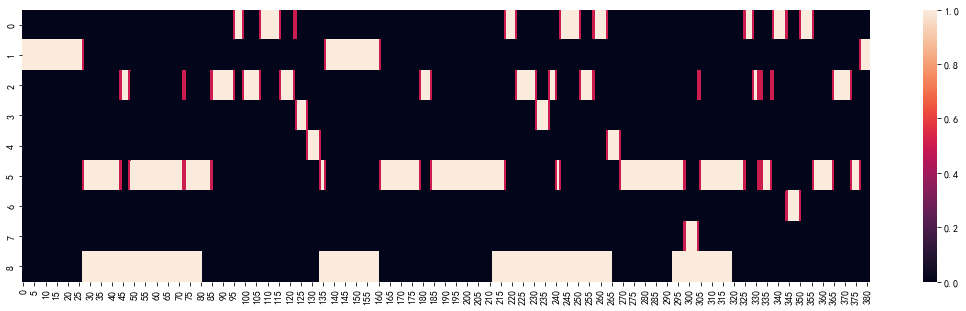

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [97]:
ShowMapForWav(3)

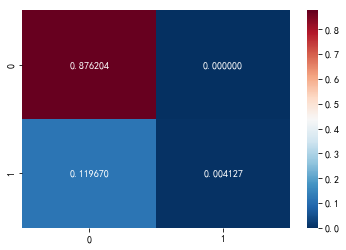

In [99]:
ShowConfusionMatrix(X, y, svm)